# Change Over Time in Early Childhood Development Metrics in Washington

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import sklearn.preprocessing
import sklearn as sk
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

## Research Question

Has there been a decline in metrics of cognition, social and emotional development, language and literacy and mathematical logic in kindergarten aged students over time in America?

In [2]:
# Reading in the data
concise = pd.read_csv("WA_statewide_metrics_concise.csv")
concise.head(10)

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf
0,10845,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,NaN,506.0,6661.0,0.07596,NaN,NaN,NaN
1,11175,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,N,1377.0,6661.0,0.20673,NaN,NaN,NaN
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN
3,37984,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,0-2 year olds,16.0,5902.0,0.00271,NaN,NaN,NaN
4,38010,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,2-year olds,157.0,5902.0,0.02660,NaN,NaN,NaN
5,38063,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,3-year olds,468.0,5902.0,0.07930,NaN,NaN,NaN
6,38223,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,4-year olds,2503.0,5902.0,0.42409,NaN,NaN,NaN
7,38484,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,Kindergarten and up,2758.0,5902.0,0.46730,NaN,NaN,NaN
8,38563,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,NaN,759.0,6661.0,0.11395,NaN,NaN,NaN
9,39027,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,N,1639.0,6661.0,0.24606,NaN,NaN,NaN


In [3]:
# Getting schoolyear
concise['schoolyear'].unique()

array(['2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17',
       '2017-18', '2018-19', '2019-20', '2021-22', '2022-23', '2023-24'],
      dtype=object)

In [4]:
concise['MeasureValue'].unique()

array([nan, 'N', 'Y', '0-2 year olds', '2-year olds', '3-year olds',
       '4-year olds', 'Kindergarten and up', 'Blue', 'Green', 'orange',
       'purple', 'Yellow'], dtype=object)

In [5]:
concise['StudentGroup'].unique()

array(['All Students', 'American Indian/ Alaskan Native',
       'Black/ African American', 'Hispanic/ Latino of any race(s)',
       'White', 'Asian', 'Native Hawaiian/ Other Pacific Islander',
       'TwoorMoreRaces'], dtype=object)

In [6]:
concise['Measure'].unique()

array(['CognitiveReadinessFlag', 'LiteracyDevelopmentLevel',
       'LiteracyReadinessFlag', 'MathDevelopmentLevel',
       'MathReadinessFlag', 'SocialEmotionalDevelopmentLevel',
       'SocialEmotionalReadinessFlag', 'CognitiveDevelopmentLevel'],
      dtype=object)

In [7]:
# Getting data only for all students, only with flags
flags = ['CognitiveReadinessFlag', 'LiteracyReadinessFlag', 'MathReadinessFlag', 'SocialEmotionalReadinessFlag']
all_students = concise[concise['Measure'].isin(flags)]
all_students_flag = all_students[all_students['StudentGroup'] == 'All Students']
all_students_flag = all_students_flag.dropna(subset = ['MeasureValue'])
all_students_flag.head()

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf
1,11175,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,N,1377.0,6661.0,0.20673,NaN,NaN,NaN
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN
9,39027,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,N,1639.0,6661.0,0.24606,NaN,NaN,NaN
10,39213,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,4263.0,6661.0,0.63999,NaN,NaN,NaN
17,40209,2011-12,State,All,All Students,Math,MathReadinessFlag,N,2469.0,6661.0,0.37067,NaN,NaN,NaN


In [8]:
# Making sure we have the correct dataCognitiveReadinessFlag
all_students_flag['StudentGroup'].unique() # looks good
all_students_flag['Measure'].unique() # looks good
all_students_flag.shape

(96, 14)

In [9]:
concise['schoolyear'].unique()

array(['2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17',
       '2017-18', '2018-19', '2019-20', '2021-22', '2022-23', '2023-24'],
      dtype=object)

In [10]:
# Creating numerical year column -- num_year represents number of years since 2011
years = concise['schoolyear'].unique()
def year_numerizer(yr):
    for i in range(len(years)):
        if yr == years[i]:
            return i
all_students_flag['num_year'] = all_students_flag['schoolyear'].apply(year_numerizer)
all_students_flag.head(10)

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf,num_year
1,11175,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,N,1377.0,6661.0,0.20673,NaN,NaN,NaN,0
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN,0
9,39027,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,N,1639.0,6661.0,0.24606,NaN,NaN,NaN,0
10,39213,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,4263.0,6661.0,0.63999,NaN,NaN,NaN,0
17,40209,2011-12,State,All,All Students,Math,MathReadinessFlag,N,2469.0,6661.0,0.37067,NaN,NaN,NaN,0
18,40236,2011-12,State,All,All Students,Math,MathReadinessFlag,Y,3534.0,6661.0,0.53055,NaN,NaN,NaN,0
25,45209,2011-12,State,All,All Students,SocialEmotional,SocialEmotionalReadinessFlag,N,2434.0,6661.0,0.36541,NaN,NaN,NaN,0
26,45513,2011-12,State,All,All Students,SocialEmotional,SocialEmotionalReadinessFlag,Y,3940.0,6661.0,0.59150,NaN,NaN,NaN,0
196,200732,2012-13,State,All,All Students,Literacy,LiteracyReadinessFlag,N,5536.0,21811.0,0.25382,NaN,NaN,NaN,1
197,200785,2012-13,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,14291.0,21811.0,0.65522,NaN,NaN,NaN,1


In [11]:
all_students_flag['num_year'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

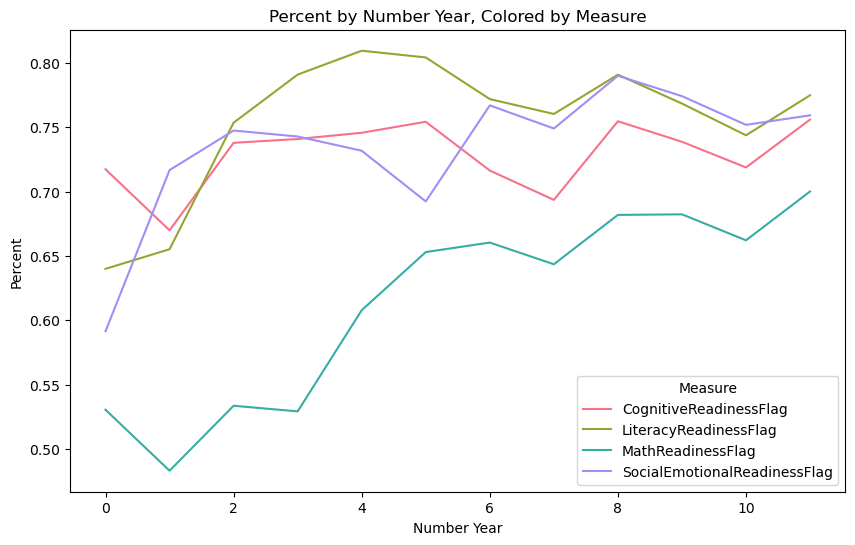

In [12]:
# Plotting the 'Percent' column by the 'num_year' column, colored by the 'Measure' column
plt.figure(figsize=(10, 6))

# Using a categorical palette from seaborn, ensuring that each measure has a consistent color
palette = sns.color_palette('husl', len(all_students_flag['Measure'].unique()))

# Create a scatter plot
sns.lineplot(data=all_students_flag[all_students_flag['MeasureValue'] == 'Y'], x='num_year', y='Percent', hue='Measure', palette=palette)

# Display the plot with a legend
plt.legend(title='Measure')
plt.xlabel('Number Year')
plt.ylabel('Percent')
plt.title('Percent by Number Year, Colored by Measure')
plt.show()

In [13]:
# Getting dataset for development levels
levels = ['LiteracyDevelopmentLevel', 'MathDevelopmentLevel', 'SocialEmotionalDevelopmentLevel', 'CognitiveDevelopmentLevel']
all_student_levels = concise[concise['Measure'].isin(levels)]
all_student_levels = all_student_levels[all_student_levels['StudentGroup'] == 'All Students']

# Creating function to convert MeasureLevels to numbers
def level_numerizer(level):
    if (level == '0-2 year olds') | (level == 'orange'):
        return 1
    elif (level == '2-year olds') | (level == 'Yellow'):
        return 2
    elif (level == '3-year olds') | (level == 'Green'):
        return 3
    elif (level == '4-year olds') | (level == "Blue"):
        return 4
    else:
        return 5

# Dropping NA values
all_student_levels = all_student_levels.dropna(subset = ['MeasureValue'])
# Adding new cols
all_student_levels['Readiness'] = all_student_levels['MeasureValue'].apply(level_numerizer) 
all_student_levels['num_year'] = all_student_levels['schoolyear'].apply(year_numerizer)


In [14]:
# Checking whether it worked
all_student_levels.head(10)

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf,Readiness,num_year
3,37984,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,0-2 year olds,16.0,5902.0,0.00271,NaN,NaN,NaN,1,0
4,38010,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,2-year olds,157.0,5902.0,0.02660,NaN,NaN,NaN,2,0
5,38063,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,3-year olds,468.0,5902.0,0.07930,NaN,NaN,NaN,3,0
6,38223,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,4-year olds,2503.0,5902.0,0.42409,NaN,NaN,NaN,4,0
7,38484,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,Kindergarten and up,2758.0,5902.0,0.46730,NaN,NaN,NaN,5,0
11,39434,2011-12,State,All,All Students,Math,MathDevelopmentLevel,0-2 year olds,147.0,6003.0,0.02449,NaN,NaN,NaN,1,0
12,39585,2011-12,State,All,All Students,Math,MathDevelopmentLevel,2-year olds,310.0,6003.0,0.05164,NaN,NaN,NaN,2,0
13,39638,2011-12,State,All,All Students,Math,MathDevelopmentLevel,3-year olds,2012.0,6003.0,0.33517,NaN,NaN,NaN,3,0
14,39665,2011-12,State,All,All Students,Math,MathDevelopmentLevel,4-year olds,1472.0,6003.0,0.24521,NaN,NaN,NaN,4,0
15,39792,2011-12,State,All,All Students,Math,MathDevelopmentLevel,Kindergarten and up,2062.0,6003.0,0.34349,NaN,NaN,NaN,5,0


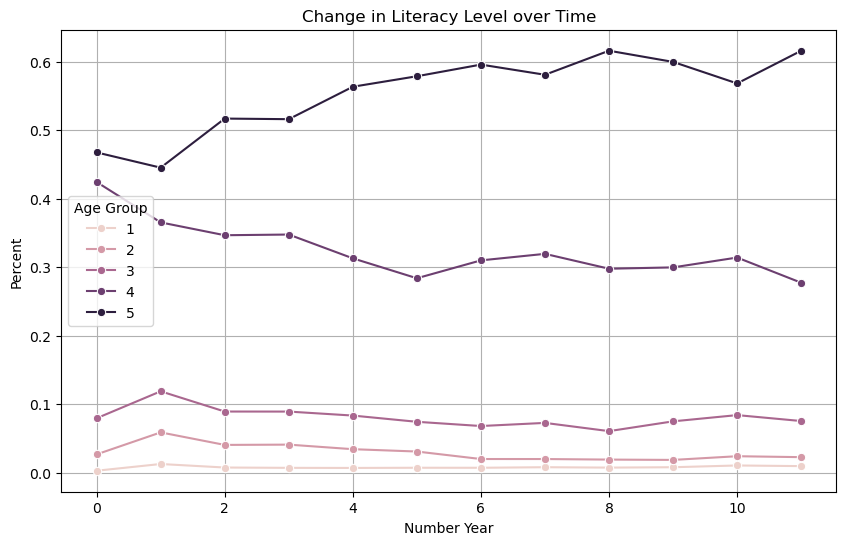

In [15]:
# Create a line plot for Literacy
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_student_levels[all_student_levels["Measure"] == 'LiteracyDevelopmentLevel'], x='num_year', y='Percent', hue='Readiness', marker='o')

# Adding details to the plot
plt.title('Change in Literacy Level over Time')
plt.xlabel('Number Year')
plt.ylabel('Percent')
plt.legend(title='Age Group')
plt.grid(True)
plt.show()

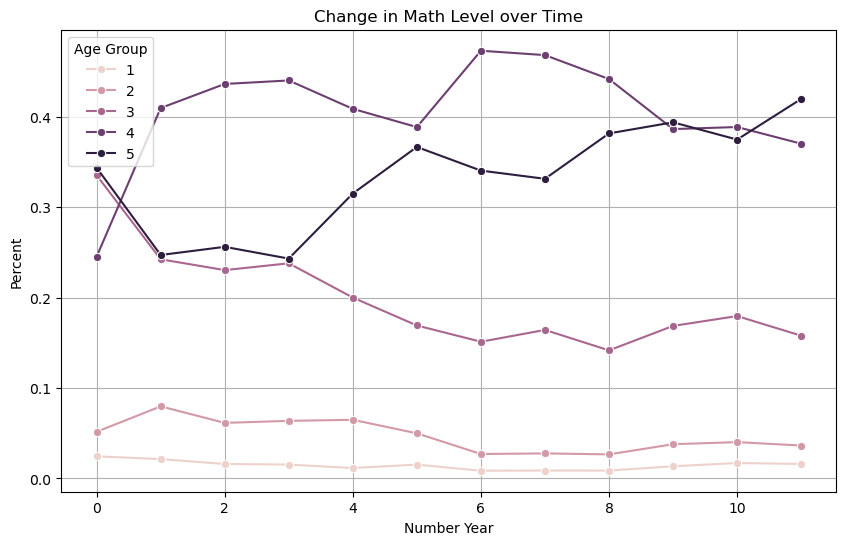

In [16]:
# Create a line plot for Math
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_student_levels[all_student_levels["Measure"] == 'MathDevelopmentLevel'], x='num_year', y='Percent', hue='Readiness', marker='o')

# Adding details to the plot
plt.title('Change in Math Level over Time')
plt.xlabel('Number Year')
plt.ylabel('Percent')
plt.legend(title='Age Group')
plt.grid(True)
plt.show()

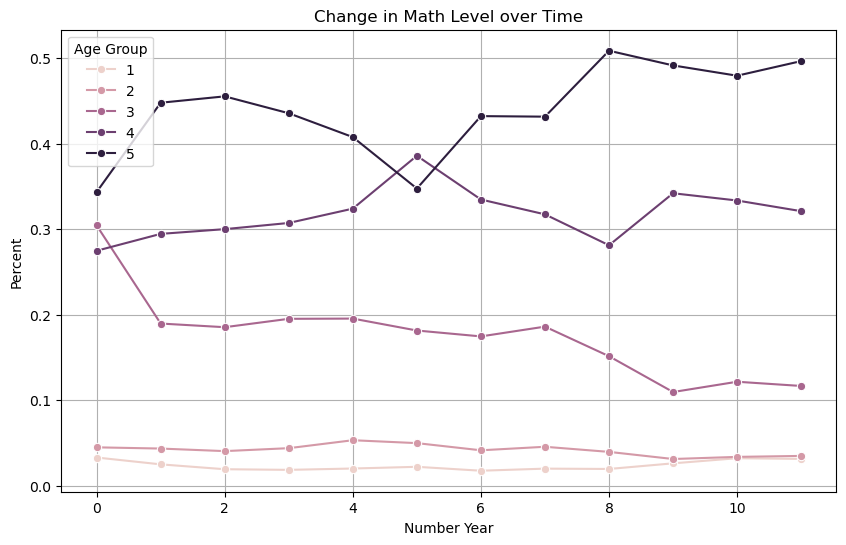

In [17]:
# Create a line plot for Social and Emotional
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_student_levels[all_student_levels["Measure"] == 'SocialEmotionalDevelopmentLevel'], x='num_year', y='Percent', hue='Readiness', marker='o')

# Adding details to the plot
plt.title('Change in Math Level over Time')
plt.xlabel('Number Year')
plt.ylabel('Percent')
plt.legend(title='Age Group')
plt.grid(True)
plt.show()

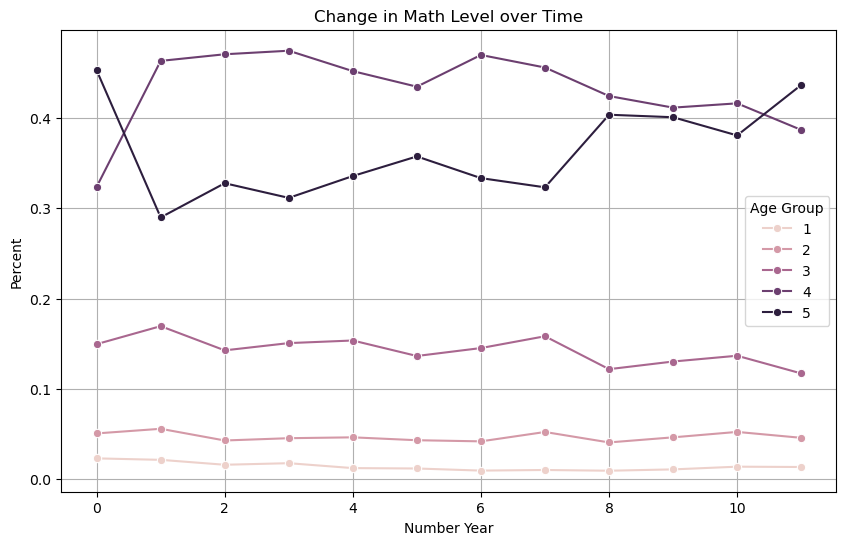

In [18]:
# Create a line plot for Cognitive
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_student_levels[all_student_levels["Measure"] == 'CognitiveDevelopmentLevel'], x='num_year', y='Percent', hue='Readiness', marker='o')

# Adding details to the plot
plt.title('Change in Math Level over Time')
plt.xlabel('Number Year')
plt.ylabel('Percent')
plt.legend(title='Age Group')
plt.grid(True)
plt.show()

## Analysis

### Chi-square test for homogeneity

In [19]:
# Getting data with only positive flags 
positive_flag = all_students_flag[all_students_flag['MeasureValue'] == 'Y']
positive_flag.head(10)

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf,num_year
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN,0
10,39213,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,4263.0,6661.0,0.63999,NaN,NaN,NaN,0
18,40236,2011-12,State,All,All Students,Math,MathReadinessFlag,Y,3534.0,6661.0,0.53055,NaN,NaN,NaN,0
26,45513,2011-12,State,All,All Students,SocialEmotional,SocialEmotionalReadinessFlag,Y,3940.0,6661.0,0.59150,NaN,NaN,NaN,0
197,200785,2012-13,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,14291.0,21811.0,0.65522,NaN,NaN,NaN,1
205,202048,2012-13,State,All,All Students,Math,MathReadinessFlag,Y,10539.0,21811.0,0.48320,NaN,NaN,NaN,1
213,207522,2012-13,State,All,All Students,SocialEmotional,SocialEmotionalReadinessFlag,Y,15631.0,21811.0,0.71666,NaN,NaN,NaN,1
221,224424,2012-13,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,14611.0,21811.0,0.66989,NaN,NaN,NaN,1
454,359422,2013-14,State,All,All Students,SocialEmotional,SocialEmotionalReadinessFlag,Y,28732.0,38443.0,0.74739,NaN,NaN,NaN,2
498,395745,2013-14,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,28365.0,38443.0,0.73785,NaN,NaN,NaN,2


In [20]:
positive_flag.head()

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf,num_year
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN,0
10,39213,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,4263.0,6661.0,0.63999,NaN,NaN,NaN,0
18,40236,2011-12,State,All,All Students,Math,MathReadinessFlag,Y,3534.0,6661.0,0.53055,NaN,NaN,NaN,0
26,45513,2011-12,State,All,All Students,SocialEmotional,SocialEmotionalReadinessFlag,Y,3940.0,6661.0,0.59150,NaN,NaN,NaN,0
197,200785,2012-13,State,All,All Students,Literacy,LiteracyReadinessFlag,Y,14291.0,21811.0,0.65522,NaN,NaN,NaN,1


In [21]:
# Pivot your data to get years as rows and categories as columns, summing the Percent values
contingency_table = positive_flag.pivot_table(index='num_year', columns='Measure', values='Numerator', aggfunc='sum')

# Replace NaN values with zeros if any
contingency_table = contingency_table.fillna(0)

# Display the contingency table
print(contingency_table)


Measure   CognitiveReadinessFlag  LiteracyReadinessFlag  MathReadinessFlag  \
num_year                                                                     
0                         4778.0                 4263.0             3534.0   
1                        14611.0                14291.0            10539.0   
2                        28365.0                28966.0            20515.0   
3                        31087.0                32272.0            22064.0   
4                        43227.0                46159.0            35281.0   
5                        58294.0                62154.0            50472.0   
6                        56660.0                61108.0            52219.0   
7                        55502.0                60778.0            51493.0   
8                        60730.0                62714.0            54854.0   
9                        55953.0                58217.0            51781.0   
10                       53875.0                55715.0         

In [22]:
# Chi-square homogeneity
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies if no association:")
print(expected)

Chi-Square Statistic: 3277.736065473149
P-value: 0.0
Degrees of Freedom: 33
Expected Frequencies if no association:
[[ 4183.88981809  4384.11915312  3661.13726827  4285.85376052]
 [13951.87284661 14619.57069336 12208.66797687 14291.88848316]
 [27000.33963258 28292.50082359 23626.80519391 27658.35434992]
 [29617.83582395 31035.26310577 25917.26055302 30339.64051726]
 [42385.85658943 44414.32584862 37089.99183872 43418.82572323]
 [56857.32725722 59578.36087035 49753.33692956 58242.97494287]
 [58462.48171604 61260.33355907 51157.93673166 59887.24799322]
 [57710.57224101 60472.43978696 50499.97394558 59117.01402645]
 [61304.43605932 64238.29593629 53644.80551007 62798.46249432]
 [56859.10062862 59580.21911038 49754.88872858 58244.79153241]
 [54638.58629284 57253.43713175 47811.81466523 55970.16191019]
 [56259.70109429 58952.13398073 49230.38065854 57630.78426645]]


In [23]:
positive_level = all_student_levels[all_student_levels['Readiness'] == 5]
positive_level.head()

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf,Readiness,num_year
7,38484,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,Kindergarten and up,2758.0,5902.0,0.46730,NaN,NaN,NaN,5,0
15,39792,2011-12,State,All,All Students,Math,MathDevelopmentLevel,Kindergarten and up,2062.0,6003.0,0.34349,NaN,NaN,NaN,5,0
23,44860,2011-12,State,All,All Students,SocialEmotional,SocialEmotionalDevelopmentLevel,Kindergarten and up,2189.0,6374.0,0.34343,NaN,NaN,NaN,5,0
111,95613,2011-12,State,All,All Students,Cognitive,CognitiveDevelopmentLevel,Kindergarten and up,2786.0,6155.0,0.45264,NaN,NaN,NaN,5,0
194,200446,2012-13,State,All,All Students,Literacy,LiteracyDevelopmentLevel,Kindergarten and up,8824.0,19827.0,0.44505,NaN,NaN,NaN,5,1


In [24]:
# Seeing how much the denominator varies
positive_flag['Denominator'].values

array([ 6661.,  6661.,  6661.,  6661., 21811., 21811., 21811., 21811.,
       38443., 38443., 38443., 38443., 42392., 41963., 40807., 41686.,
       57030., 58043., 58279., 57972., 77291., 77291., 77291., 77291.,
       79099., 79175., 79073., 79253., 80027., 79944., 80016., 80146.,
       80481., 79306., 80447., 80626., 75889., 75556., 75770., 75748.,
       74960., 74916., 74952., 75091., 74281., 74144., 74244., 74424.])

In [25]:
positive_flag[(positive_flag['Measure'] == 'CognitiveReadinessFlag') & (positive_flag['num_year'] == 1)]['Numerator'].iloc[0]

14611.0

In [26]:
from statsmodels.stats.proportion import proportions_ztest

# Is there a significant difference in proportions with a positive flag between years?

def z_tester_flag(year1, year2, flag, data):
    # Filter the data for the specified year and flag
    data_year1 = data[(data['Measure'] == flag) & (data['num_year'] == year1)]
    data_year2 = data[(data['Measure'] == flag) & (data['num_year'] == year2)]
    
    # If either year does not have data for the flag, return None or a placeholder
    if data_year1.empty or data_year2.empty:
        return None, None
    
    # Retrieve the Numerator and Denominator
    year1_passed = data_year1['Numerator'].iloc[0]
    year1_denom = data_year1['Denominator'].iloc[0]
    year2_passed = data_year2['Numerator'].iloc[0]
    year2_denom = data_year2['Denominator'].iloc[0]
    
    # Perform the z-test for two proportions
    stat, pval = proportions_ztest([year1_passed, year2_passed], [year1_denom, year2_denom])
    return stat, pval

def z_tester_readiness(year1, year2, level, data):
    # Filter the data for the specified year and flag
    data_year1 = data[(data['Measure'] == level) & (data['num_year'] == year1)]
    data_year2 = data[(data['Measure'] == level) & (data['num_year'] == year2)]
    
    # If either year does not have data for the flag, return None or a placeholder
    if data_year1.empty or data_year2.empty:
        return None, None
    
    # Retrieve the Numerator and Denominator
    year1_passed = data_year1['Numerator'].iloc[0]
    year1_denom = data_year1['Denominator'].iloc[0]
    year2_passed = data_year2['Numerator'].iloc[0]
    year2_denom = data_year2['Denominator'].iloc[0]
    
    # Perform the z-test for two proportions
    stat, pval = proportions_ztest([year1_passed, year2_passed], [year1_denom, year2_denom])
    return stat, pval

In [27]:
all_students_flag['num_year'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Pairwise comparisons of years
Note: since we are making so many pairwise comparisons (55) we need to have a p-value of 0.05 / 55= 0.000909 to reach the alpha = 0.05 significance level

In [28]:
# Getting dictionaries of 55 pairwise comparisons for flag data: this can tell us the proper p-value
def flag_dictionarizer(flag, data):
    num_years = 11
    flag_pairwise = {}
    for i in range(num_years):
        for j in range(i+1):
            if i !=j:
                flag_pairwise[f'{i} vs {j}'] = z_tester_flag(i, j, flag, data)
    return flag_pairwise

math_pairwise = pd.DataFrame(flag_dictionarizer('MathReadinessFlag', positive_flag))
lit_pairwise = flag_dictionarizer('LiteracyReadinessFlag', positive_flag)
cog_pairwise = flag_dictionarizer('CognitiveReadinessFlag', positive_flag)
soc_pairwise = flag_dictionarizer('SocialEmotionalReadinessFlag', positive_flag)


In [29]:
# Creating matrices of z-stats
def z_matrix(flag, data, parameter):
    N = 12  # Number of items to compare
    flag_matrix = np.ones((N, N))  # Initialize a 2D array (matrix) filled with zeros
    # Populate the matrix with pairwise comparisons
    for i in range(N):
        for j in range(i+1, N):  # Start from i+1 to avoid self-comparison and duplicate comparisons
            comparison_result = z_tester_flag(i, j, flag, data)
            flag_matrix[i, j] = comparison_result[parameter]
            flag_matrix[j, i] = comparison_result[parameter]
    return flag_matrix

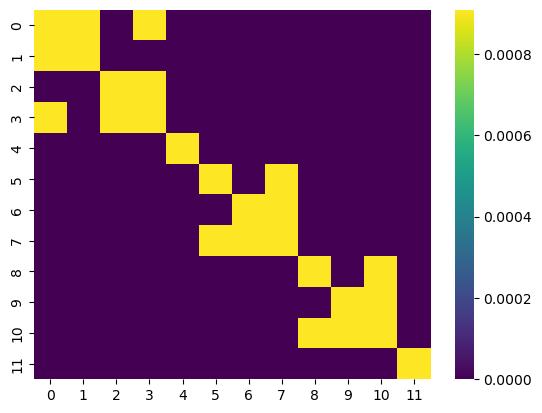

In [30]:
# Getting heatmaps for some flag
mathflag_matrix = z_matrix('MathReadinessFlag', positive_flag, 0)
sns.heatmap(mathflag_matrix, vmin=0, vmax =  0.000909, cmap='viridis')
plt.show()

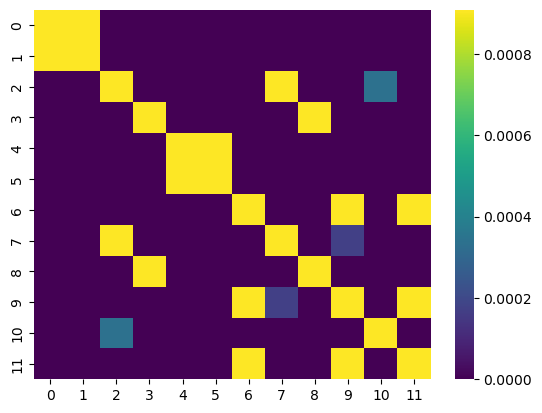

In [31]:
litflag_matrix = z_matrix('LiteracyReadinessFlag', positive_flag, 1)
sns.heatmap(litflag_matrix, vmin=0, vmax =  0.000909, cmap='viridis')
plt.show()

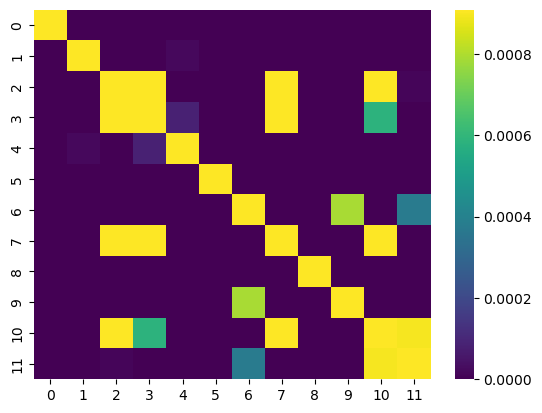

In [32]:
socflag_matrix = z_matrix('SocialEmotionalReadinessFlag', positive_flag, 1)
sns.heatmap(socflag_matrix, vmin=0, vmax =  0.000909,cmap='viridis')
plt.show()

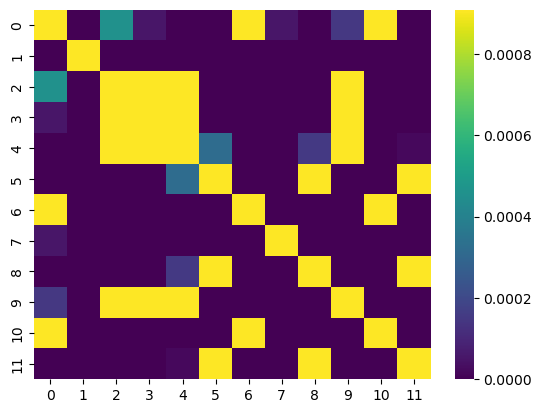

In [33]:
cogflag_matrix = z_matrix('CognitiveReadinessFlag', positive_flag, 1)
sns.heatmap(cogflag_matrix, vmin=0, vmax =  0.000909, cmap='viridis')
plt.show()